In [1]:
import os
import numpy as np
import muspy
from tqdm import tqdm
import config
import utils
import tarfile
import shutil
import collections
from matplotlib import pyplot as plt
import json
import tensorflow as tf
import pickle

config_string = "single_instruments_type"
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

conf = config.Config(config_string, ROOT_PATH)

# chosen_datasets = ["lmd_matched"]

# TODO: create loss for durations (MSE)

/home/aborghesi/persistent/MusicGeneration/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-16 08:41:25.469965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 08:41:25.600059: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 08:41:25.633282: E tensorflow/stream_executor/cuda/c

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-05-16 08:41:27.084918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 08:41:28.853123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-05-16 08:41:28.853729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 28069 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


# Warning, ~ 10 hours required

In [2]:
dataset = utils.get_dataset("lmd_matched", conf)

with open(os.path.join(conf.dataset_paths["lmd_matched"], "lakh_matched_genre_vectors.pickle"), "rb") as f:
    genre_vectors = pickle.load(f)


---
## Data exploration

In [3]:
print(len(dataset))
flag = False
for i in tqdm(range(len(dataset))):

    # check if same instrument is used multiple times
    # if collections.Counter(np.unique(list(track.program for track in dataset[i].tracks)))  \
    #     != collections.Counter(list(track.program for track in dataset[i].tracks)):
    #     print(i)
    
    # check if there are key_signatures
    # if len(k_signs := dataset[i].key_signatures) > 1: 
    #     print(k_signs)
    #     print(i)

    # if len(t_signs := dataset[i].time_signatures) > 1: 
    #     print(t_signs)
    #     print(i)

    # if len(tempo := dataset[i].tempos) > 1: 
    #     print(tempo)
    #     print(i)

    # for track in dataset[i].tracks:
    #     if track.is_drum:
    #         print(i)
    break


115190


  0%|          | 0/115190 [00:00<?, ?it/s]


In [4]:
dataset[0].tracks[0].notes[0]

Note(time=7, pitch=69, duration=64, velocity=100)

In [5]:
def get_stats(dataset):
    stats = {
        "n_tracks" : np.zeros(1000),            # how many instruments are playing in a song (can also be 2 of the same instrument)
        "programs" : np.zeros(1000),             # which type of instrument
        "pitch": np.zeros(500),
        "velocity" : np.zeros(128),             # how loud (0-127)
        "durations": {},          # how many quarters does the note last(?)
        "drum_durations": {},
        "tempos": [],                           # how fast is the song in qpm (quarters per minute) --> can be non integer
        "time_signatures": {},                  # 4/4 or 3/4 etc... store it as a dict
        "key_signatures": {},        # which is the main key
        "len_notes": [],
        "len_drums": []
    }

    for song, genre in (pbar := tqdm(zip(dataset, genre_vectors), total=len(dataset))):
        pbar.set_description("Long dataset matched")
        
        if not type(genre) == type(None):

            resolution = song.resolution
            # how many tracks are in the song (tracks = different "instrument voices" but could be 4 pianos)
            stats["n_tracks"][len(song)] += 1 


            # how many different instruments and which
            programs = np.unique(list(track.program for track in song.tracks))  
            for program in programs:
                stats["programs"][program] += 1


            # stats on key signatures
            key_signatures = list(set((key_sign.root, key_sign.mode) for key_sign in song.key_signatures)) 

            for key_sign in key_signatures:
                if key_sign in stats["key_signatures"].keys():
                    stats["key_signatures"][key_sign] += 1
                else:
                    stats["key_signatures"][key_sign] = 1


            # stats on time_signatures --> need to know which exist / are used to create possible tokens
            time_signatures = list(set((time_sign.numerator, time_sign.denominator) for time_sign in song.time_signatures)) 

            for time_sign in time_signatures:
                if time_sign in stats["time_signatures"].keys():
                    stats["time_signatures"][time_sign] += 1
                else:
                    stats["time_signatures"][time_sign] = 1

            # stats on tempos
            tempos = list(set(tempo.qpm for tempo in song.tempos))

            for tempo in tempos:
                stats["tempos"].append(tempo)

            # notes
            tot_notes = 0
            tot_drums = 0
            for track in song.tracks:

                if len(track) > 0:
                    stats["programs"][track.program] += 1

                    if track.is_drum:
                        tot_drums += len(track.notes)

                        for note in track.notes:

                            stats["pitch"][note.pitch + 128] += 1
                            stats["velocity"][note.velocity] += 1

                            # duration / resolution = duration in beath lengths
                            if (dur := note.duration / resolution) in stats["drum_durations"].keys():
                                stats["drum_durations"][dur] += 1
                            else:
                                stats["drum_durations"][dur] = 1
                    else:
                        tot_notes += len(track.notes)

                        for note in track.notes:
                            stats["pitch"][note.pitch] += 1
                            stats["velocity"][note.velocity] += 1

                            # duration / resolution = duration in beath lengths
                            if (dur := note.duration / resolution) in stats["durations"].keys():
                                stats["durations"][dur] += 1
                            else:
                                stats["durations"][dur] = 1

            stats["len_notes"].append(tot_notes)
            stats["len_drums"].append(tot_drums)
    return stats

In [ ]:
stats = get_stats(dataset)            

Long dataset matched:  31%|███       | 35164/115190 [19:19<46:07, 28.92it/s]  

In [ ]:
def plot_scatter_limit(a, lim=-1):
    plt.scatter(range(len(a[:lim])), np.sort(a)[:lim]);


def plot_bar_centered(a, lim=None):
    min_idx = len(a)
    max_idx = 0
    for i, n in enumerate(list(a)):
        if n>0:
            if i < min_idx:
                min_idx = i
            if i > max_idx:
                max_idx = i

    plt.figure(figsize=(26,5))
    if lim != None:
        plt.bar(range(len(a[lim[0]:lim[1]])), a[lim[0]:lim[1]])
        plt.xticks(ticks=range(0,lim[1]-lim[0]), labels=range(lim[0], lim[1]), rotation=90);
        print("The remaining not shown values amount to {:.2f}% of the total".format((sum(a[lim[1]:])+sum(a[:lim[0]]))/sum(a)*100))
    else:
        plt.bar(range(len(a[min_idx:max_idx])), a[min_idx:max_idx])
        plt.xticks(ticks=range(0,max_idx-min_idx), labels=range(min_idx, max_idx), rotation=90);


def plot_scatter_from_dict(
        d, 
        lim_percentage=0, 
        mapping=None, 
        conf: config.Config = None ):

    if mapping == None:
        mapping = lambda x, y: x

    tot = np.sum(list(d.values()))
    arr = np.zeros((len(d.keys()), 2))
    for i, key in enumerate(d.keys()):
        arr[i,0] = mapping(key, conf)
        arr[i,1] = d[key]/tot*100

    plt.scatter([x[0] for x in arr if x[1] > lim_percentage], [x[1] for x in arr if x[1] > lim_percentage])
    print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[1] for x in arr if x[1] <= lim_percentage])/sum(arr[:,1])*100))


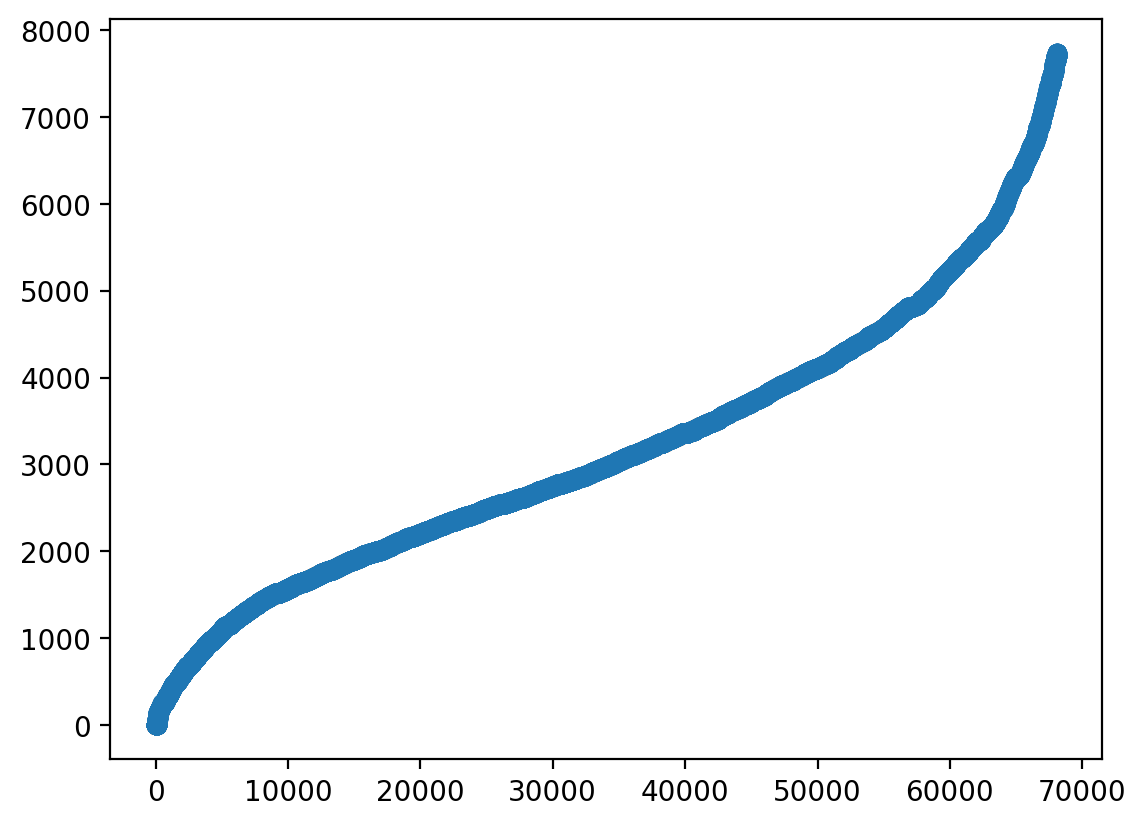

In [10]:
plot_scatter_limit(stats["len_notes"], lim=-2000)

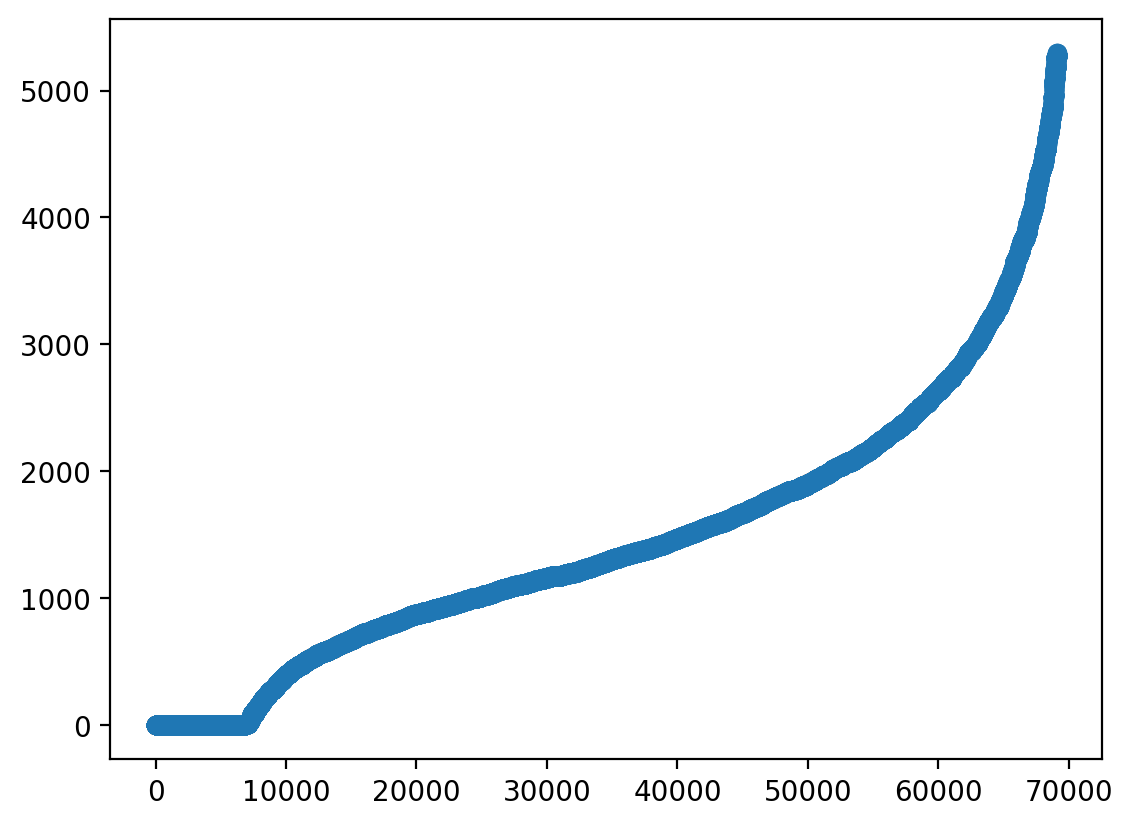

In [12]:
plot_scatter_limit(stats["len_drums"], lim=-1000)

The remaining not shown values amount to 0.15% of the total


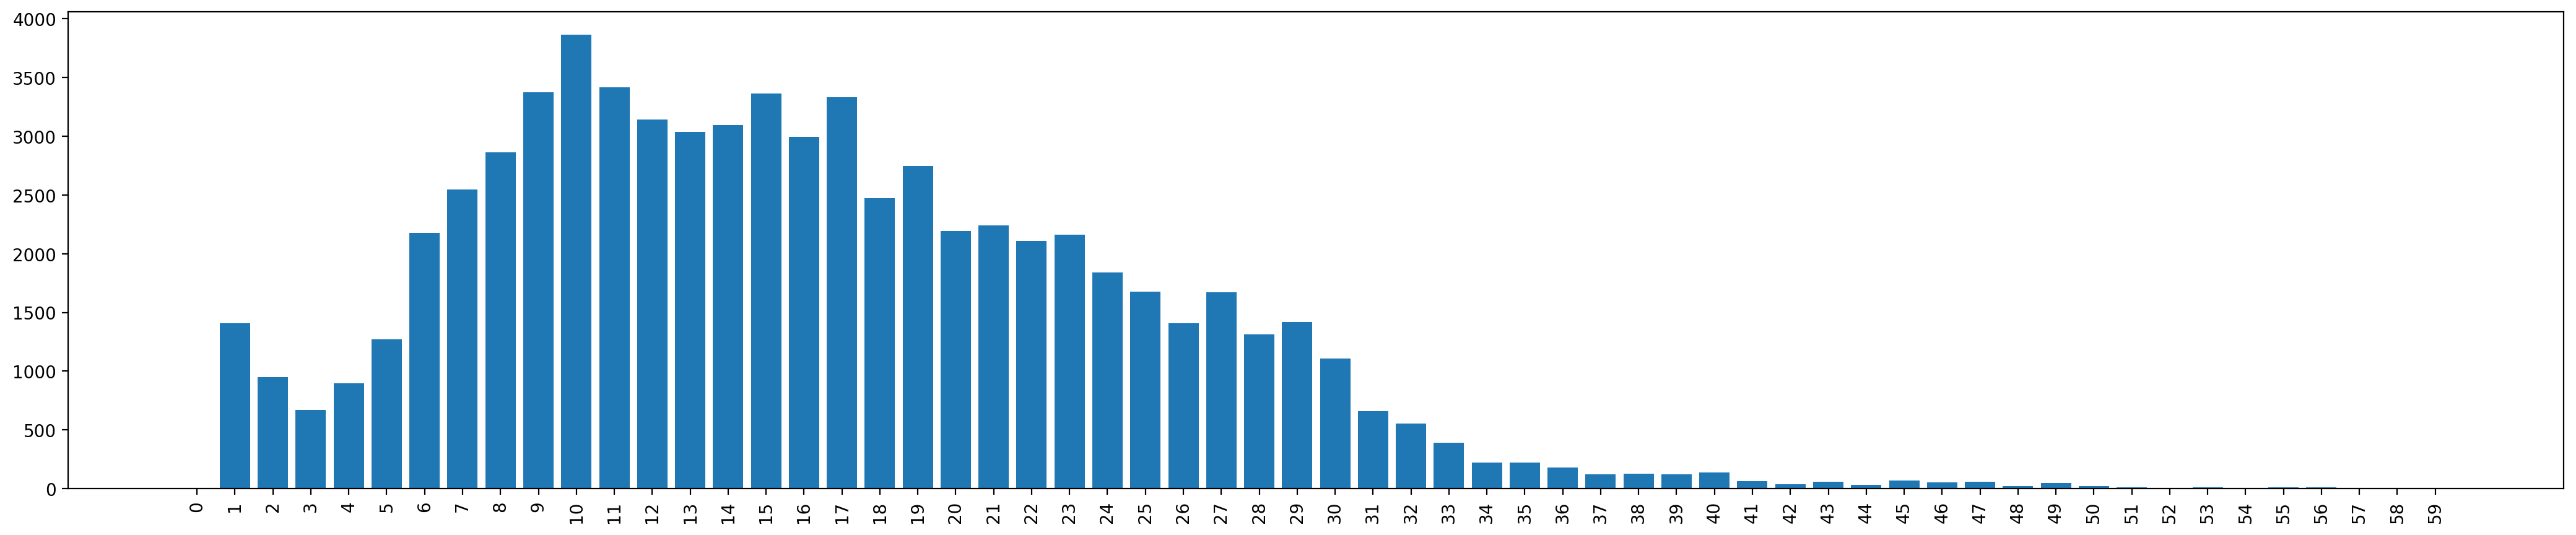

In [14]:
plot_bar_centered(stats["n_tracks"], lim=[0, 60])

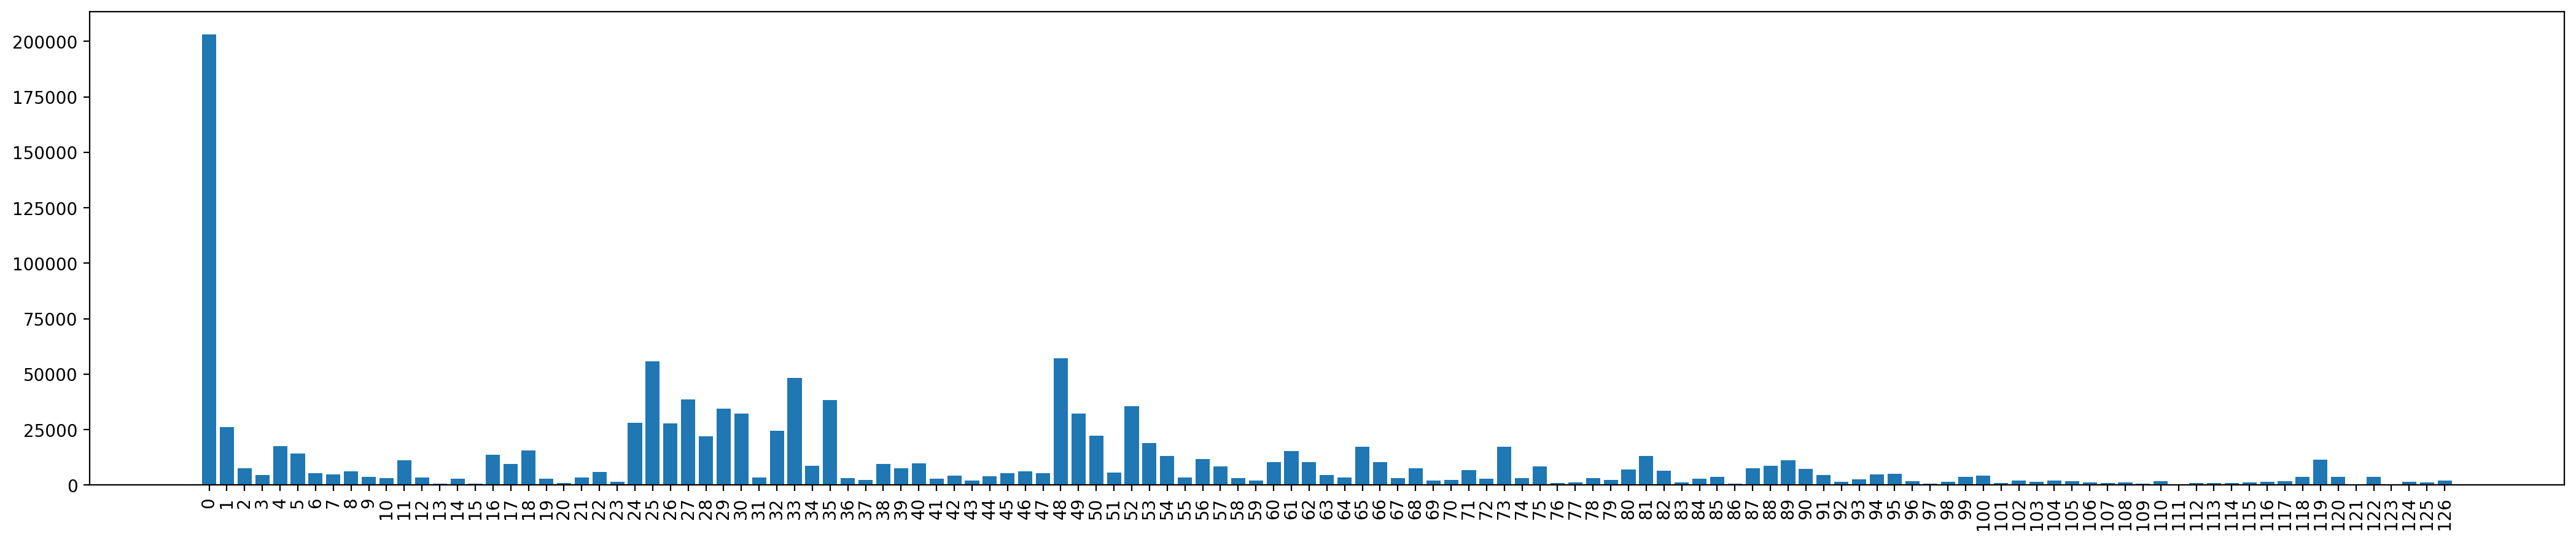

In [15]:
plot_bar_centered(stats["programs"])

The remaining not shown values amount to 68.80% of the total


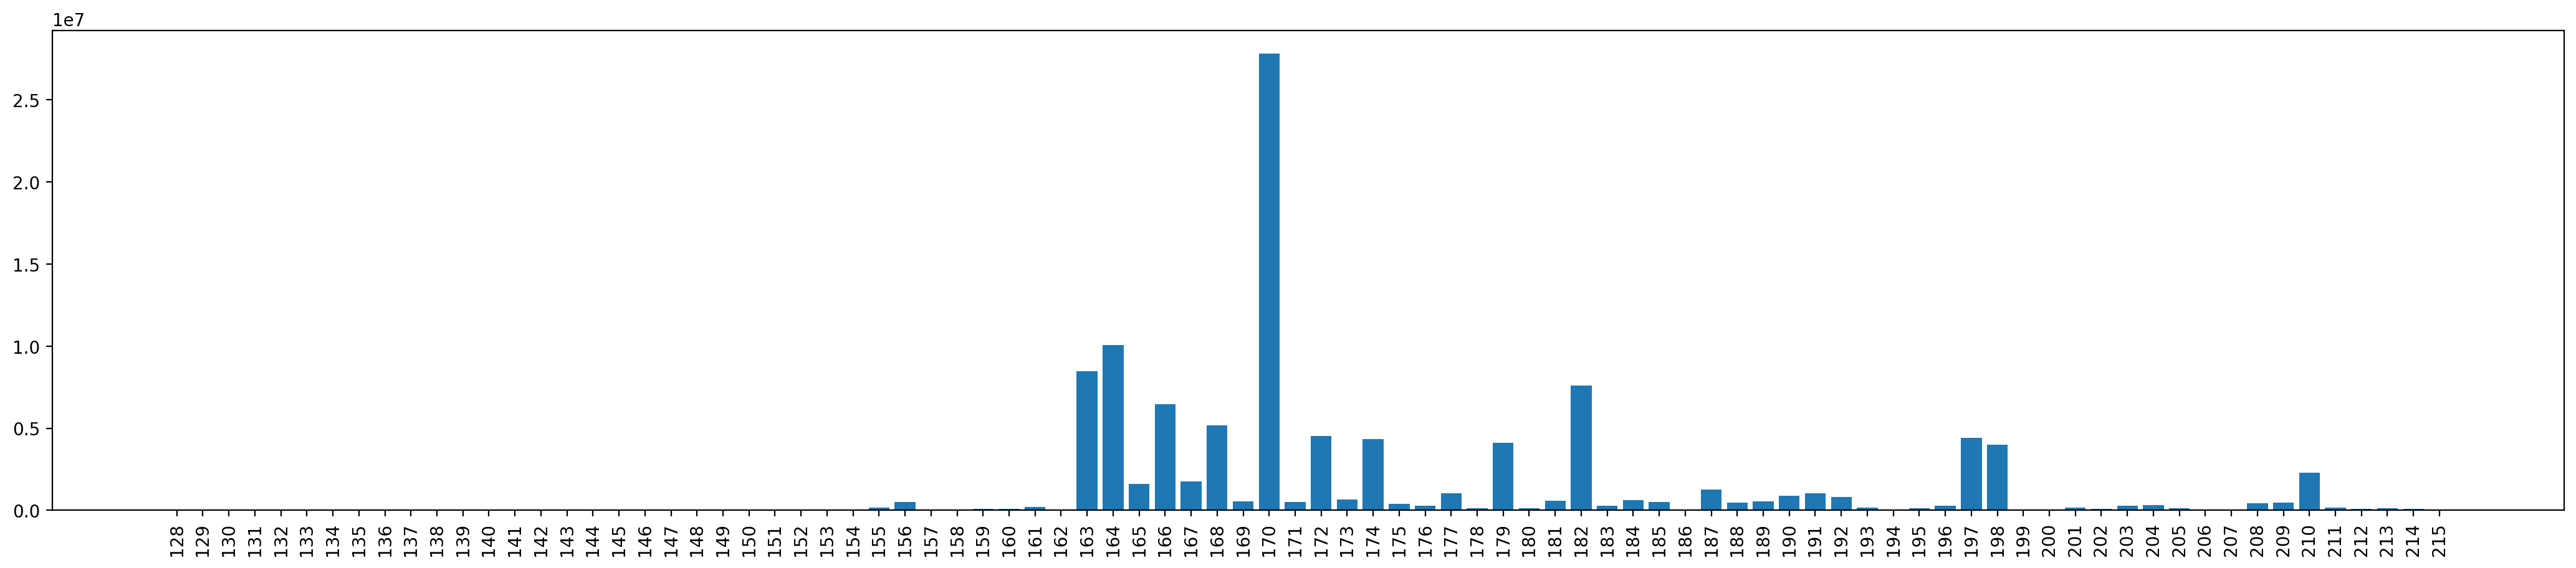

In [19]:
plot_bar_centered(stats["pitch"], lim=[128, 216])


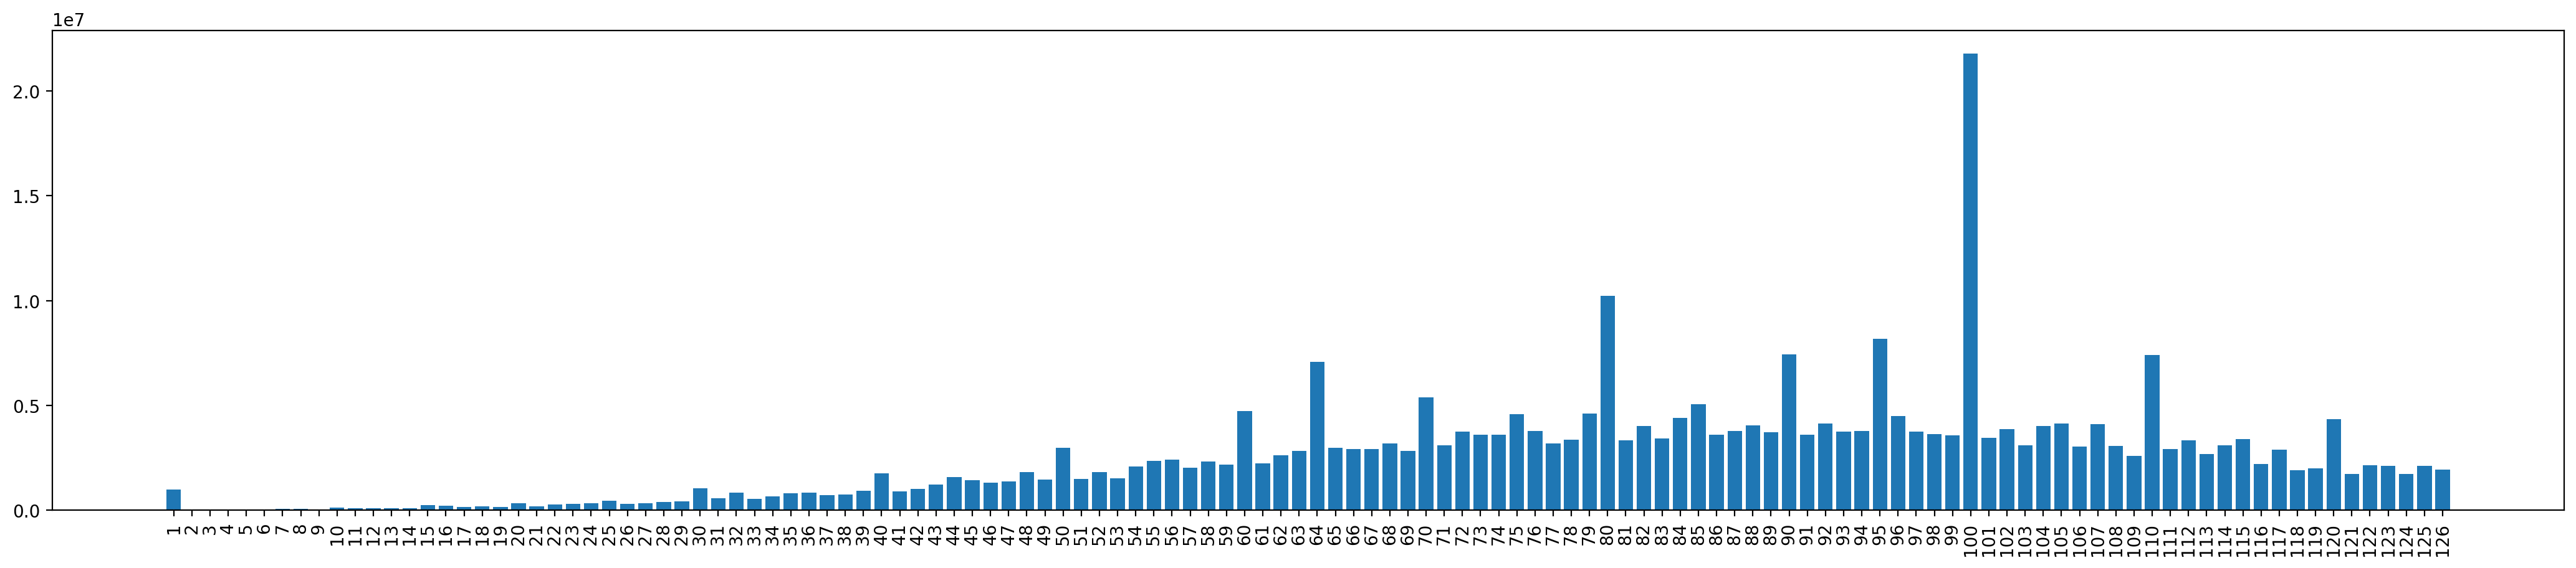

In [20]:
plot_bar_centered(stats["velocity"])

In [39]:
tot_diff = 0
tot_notes = 0

for dur, freq in stats["durations"].items():
    #if dur > min(conf.np_durations) and dur < max(conf.np_durations):
    #if dur < max(conf.np_durations):
    #if dur > min(conf.np_durations):
        selected_dur = conf.np_durations[np.argmin(np.abs(conf.np_durations - dur))]
        diff = np.abs(selected_dur - dur)
        # print(dur, selected_dur, diff)
        tot_diff += diff*freq
        tot_notes += freq

print(tot_diff/tot_notes, tot_notes)

0.016207170030481395 237347866


The remaining not shown values amount to 29.63% of the total


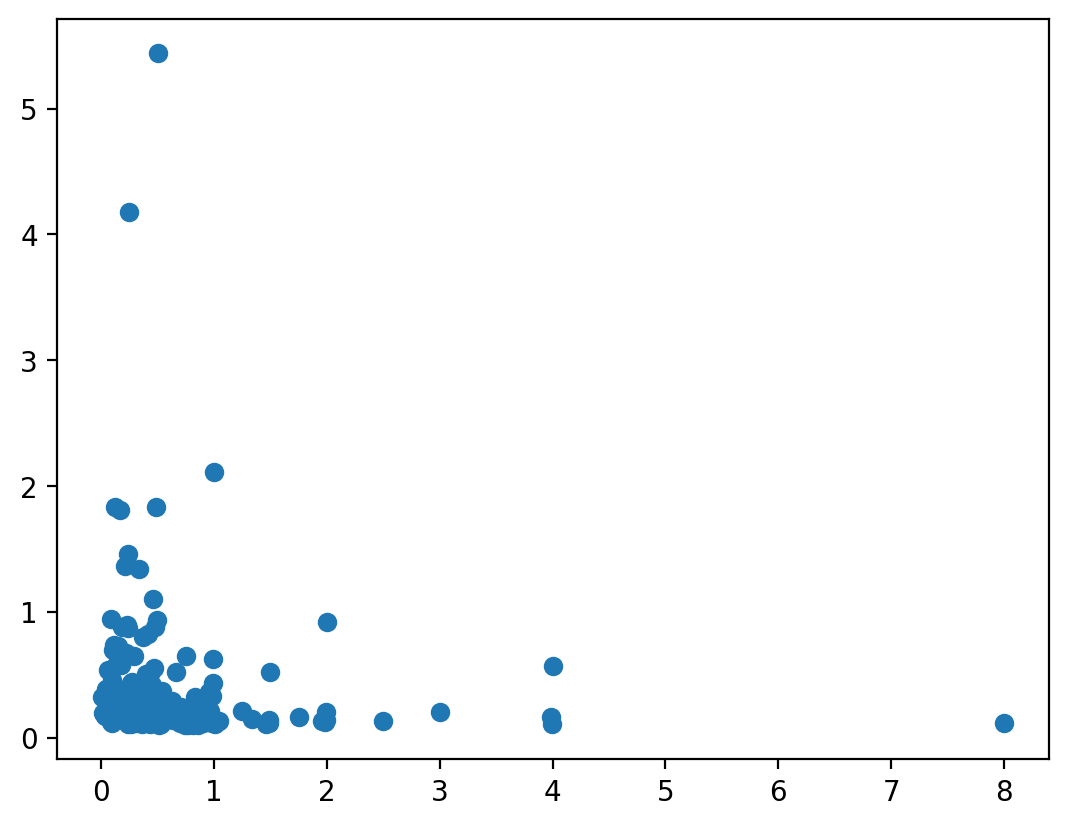

In [24]:
plot_scatter_from_dict(stats["durations"], lim_percentage=1/10)

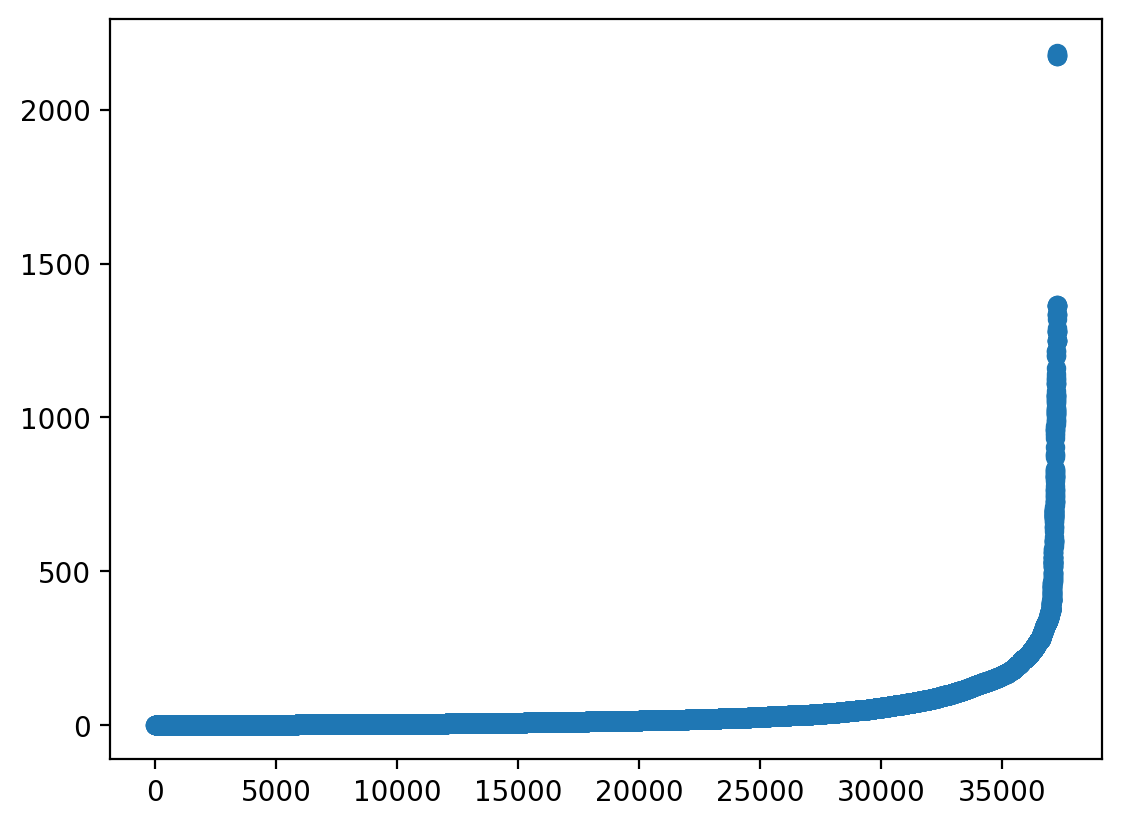

In [33]:
plot_scatter_limit(list(stats["durations"].keys()))

In [43]:
tot_diff = 0
tot_notes = 0

for dur, freq in stats["drum_durations"].items():
    if dur > min(conf.np_durations) and dur < max(conf.np_durations):
    #if dur < max(conf.np_durations):
    #if dur > min(conf.np_durations):
        selected_dur = conf.np_durations[np.argmin(np.abs(conf.np_durations - dur))]
        diff = np.abs(selected_dur - dur)
        # print(dur, selected_dur, diff)
        tot_diff += diff*freq
        tot_notes += freq

print(tot_diff/tot_notes, tot_notes)

0.003621198883493149 88366104


The remaining not shown values amount to 35.33% of the total


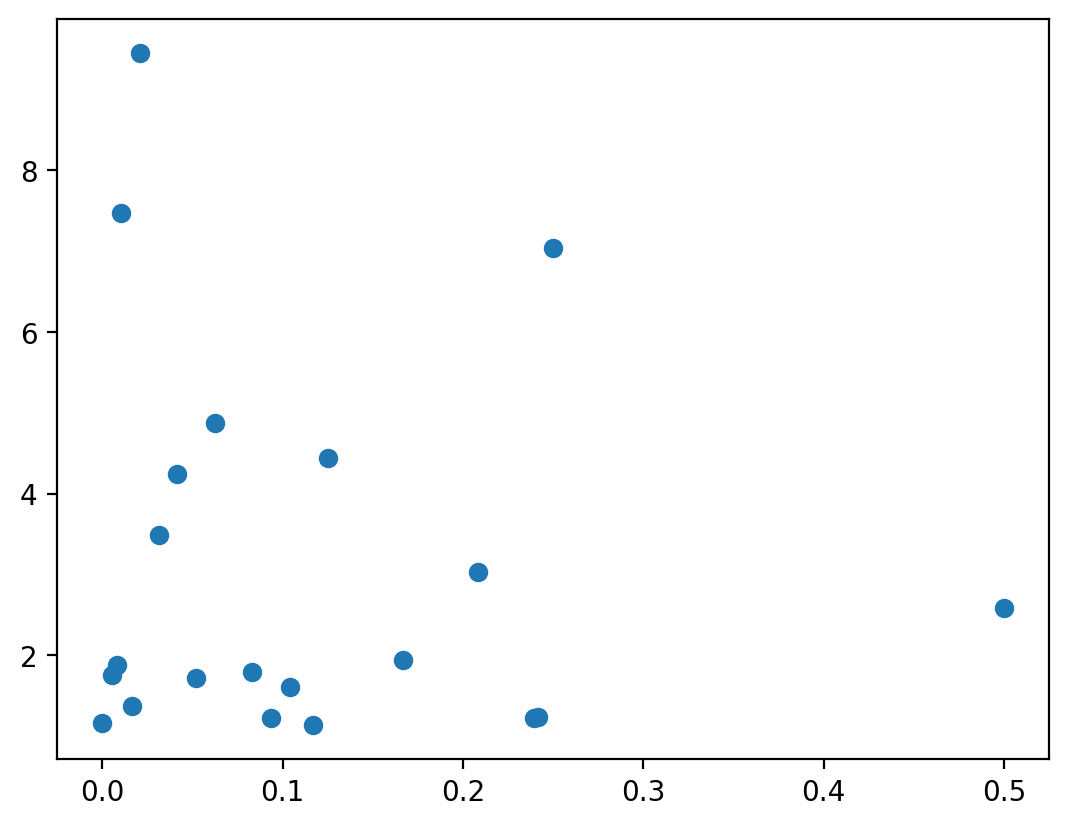

In [30]:
plot_scatter_from_dict(stats["drum_durations"], lim_percentage=1)

In [47]:
tot_diff = 0
tot_notes = 0

for tempo in stats["tempos"]:
    #if dur > min(conf.np_durations) and dur < max(conf.np_durations):
    #if dur < max(conf.np_durations):
    #if dur > min(conf.np_durations):
        selected_tempo = conf.np_tempos[np.argmin(np.abs(conf.np_tempos - tempo))]
        diff = np.abs(selected_tempo - tempo)
        # print(dur, selected_dur, diff)
        tot_diff += diff
        tot_notes += 1

print(tot_diff/tot_notes, tot_notes)

1.4296549092917106 461736


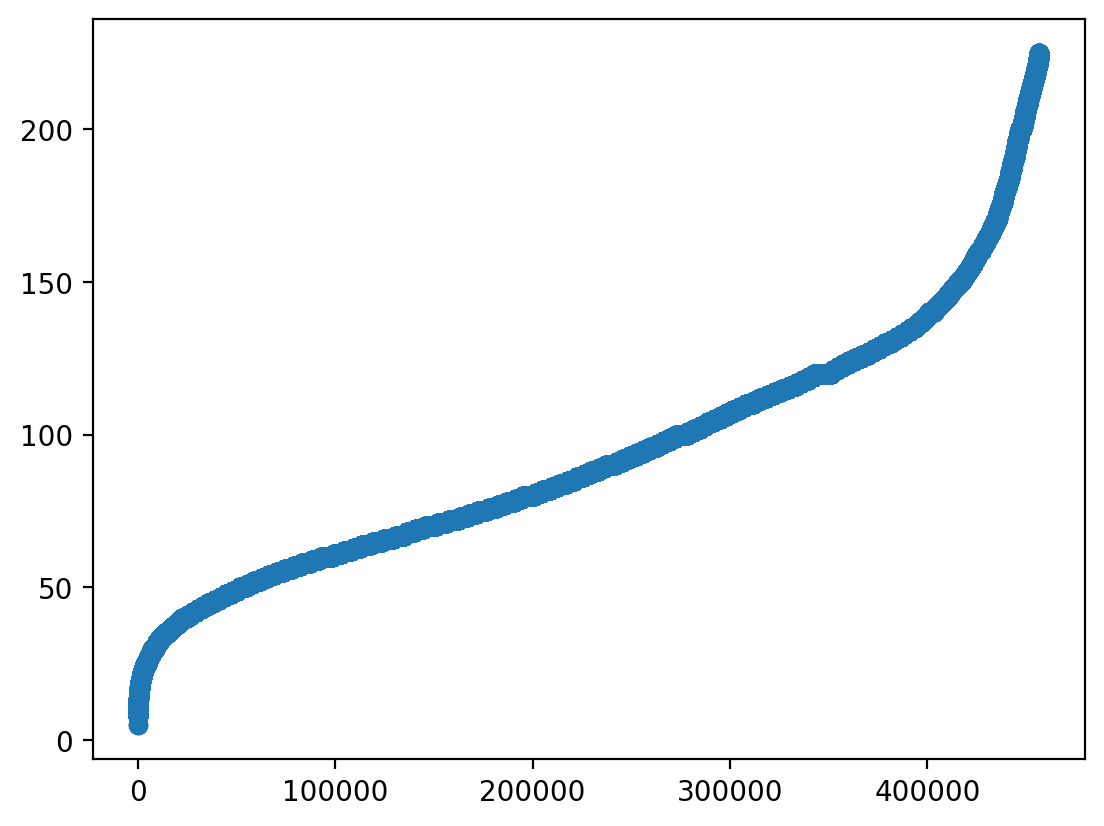

In [45]:
plot_scatter_limit(stats["tempos"], lim=-5000)

The remaining not shown values amount to 0.00% of the total


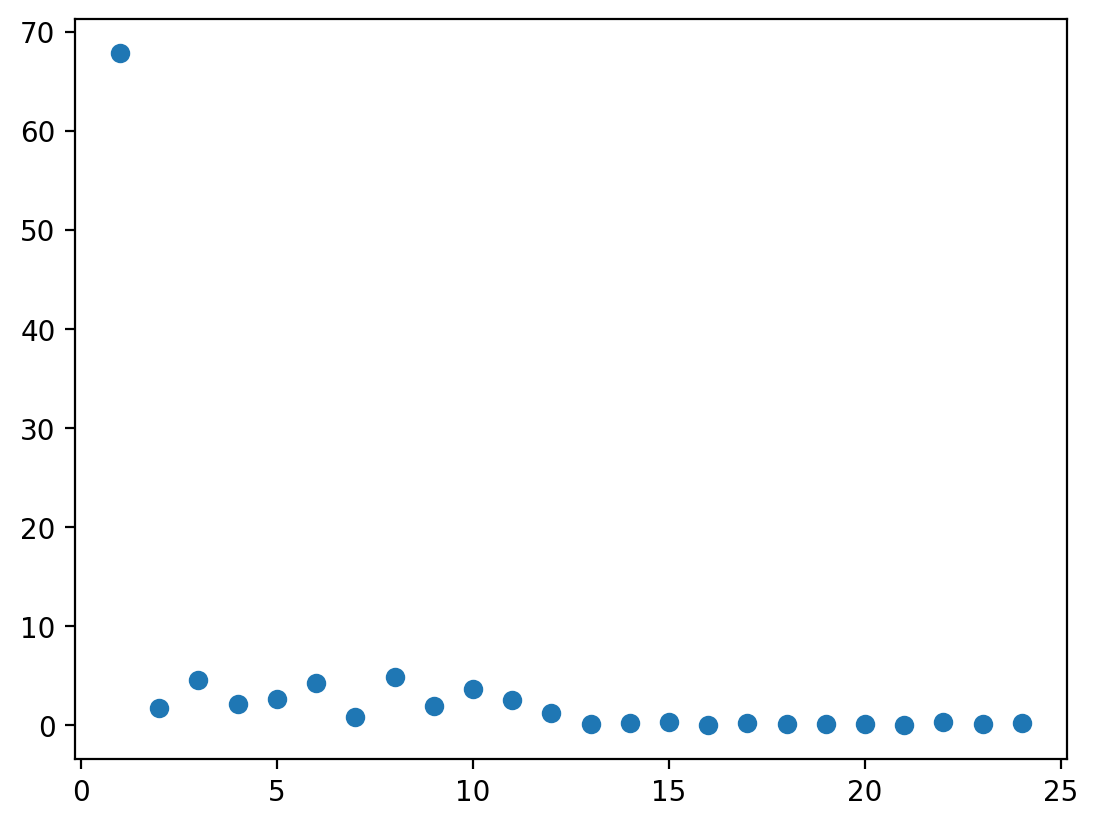

In [20]:
plot_scatter_from_dict(stats["key_signatures"], mapping=utils.key_sign_map)

In [50]:
tot = np.sum(list(stats["time_signatures"].values()))
print(tot)
print()
arr = np.zeros((len(stats["time_signatures"].keys()), 3))

for i, key in enumerate(stats["time_signatures"].keys()):
    arr[i,0] = stats["time_signatures"][key]/tot*100
    arr[i,1] = key[0]
    arr[i,2] = key[1]

arr = arr[arr[:,0].argsort()]

# Numerators
lim_percentage = 0.01
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[1] for x in arr if x[0]>lim_percentage])))))
num_nominators = len(tmp)
print("Total number of accepted numerators {}".format(num_nominators))
print()
# Denominators
lim_percentage = 0
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[2] for x in arr if x[0]>lim_percentage])))))
num_denominators = len(tmp)
print("Total number of accepted denominators {}".format(num_denominators))

print("Total possible time_signatures: {}".format(num_nominators*num_denominators))
# for i in arr:
#     print("{:5.2f}%, {:.0f}/{:.0f}".format(i[0], i[1], i[2]))

76693

The remaining not shown values amount to 0.11% of the total
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  15.
  16.  17.  21. 149.]
Total number of accepted numerators 18

The remaining not shown values amount to 0.00% of the total
[ 2.  4.  8. 16. 32.]
Total number of accepted denominators 5
Total possible time_signatures: 90


In [26]:
def duration_loss(possible_durations: np.array, real_durations: dict, limit_max_len=1e10) -> float:
    loss = 0
    tot_notes = 0
    for dur, num_notes in real_durations.items():
        if dur < limit_max_len:
            new_val = possible_durations[np.argmin(np.abs(possible_durations - dur))]
            loss += np.abs(new_val - dur) * num_notes
            tot_notes += num_notes

    return loss/tot_notes

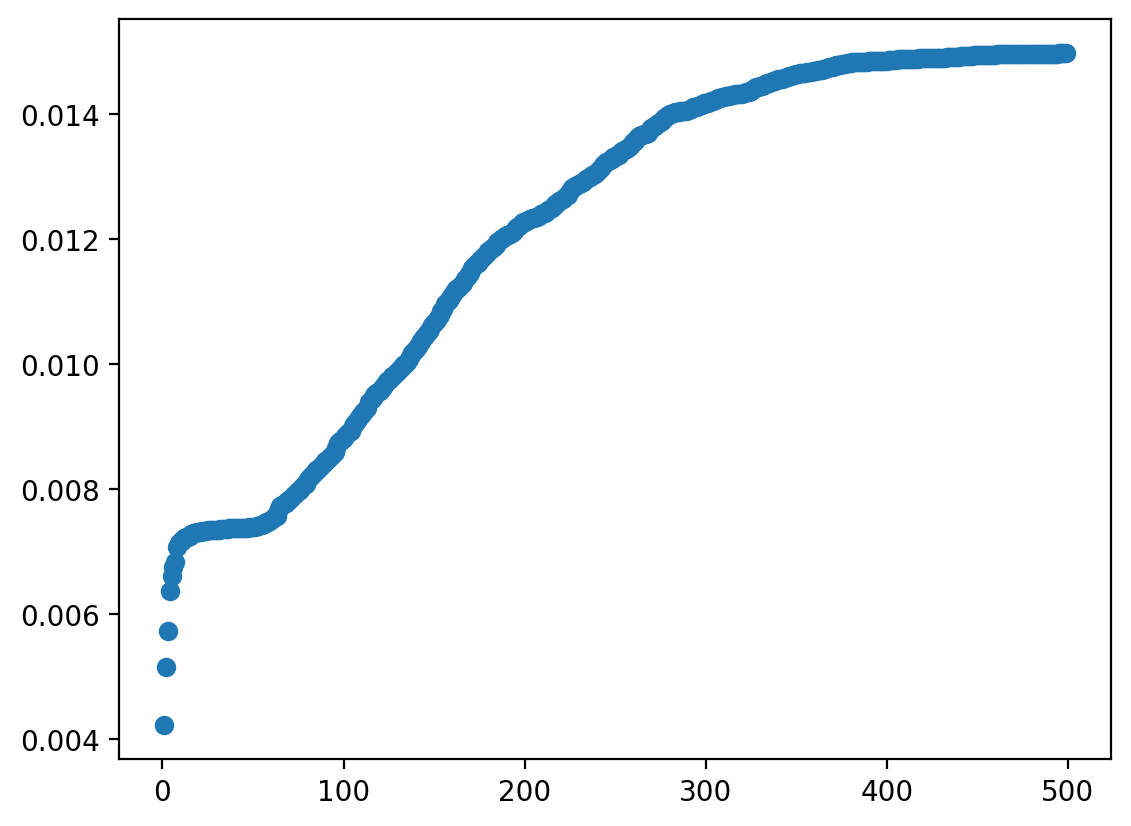

In [28]:
# The mean error with our discretization on "short" (<48 beats) note is 0.67%, if we add long notes it becomes ~2%
plt.scatter(
    range(1,500),
    [duration_loss(conf.np_durations, stats["durations"], limit_max_len=i) for i in np.linspace(1, 500, 50)]
)
plt.xlabel("Maximum length allowed (i.e. snap longer notes to limit_max_len)")

In [29]:
duration_loss(conf.np_durations, stats["durations"], limit_max_len=max(conf.np_durations))

0.007391564897058901

# Song transformation

In [52]:
min = 10000000
idx = -1
for i, song in tqdm(enumerate(dataset)):
    len_song = np.sum([len(track.notes) for track in song.tracks if len(track.notes) > 0])
    if len_song < min and len_song > 0:
        min = len_song
        idx = i

print(min, idx)

751it [00:23, 32.65it/s]


KeyboardInterrupt: 

In [54]:
# for track in dataset[50].tracks:
#     print(track.notes)

In [57]:
song = utils.transform_representation(dataset[50], conf)
print("     type   measure      beat  position  duration    pitch instrument  velocity  key_sign  time_sign    tempo")
for line in song[:20, :]:
    print("{:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f} {:9.0f}".format(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7], line[8], line[9], line[10]))

     type   measure      beat  position  duration    pitch instrument  velocity  key_sign  time_sign    tempo
        0         0         0         0         0         0         0         0         0         0         0
        1         0         0         0         0         0        35         0         0         0         0
        1         0         0         0         0         0         2         0         0         0         0
        1         0         0         0         0         0        66         0         0         0         0
        1         0         0         0         0         0         2         0         0         0         0
        1         0         0         0         0         0        50         0         0         0         0
        1         0         0         0         0         0        28         0         0         0         0
        1         0         0         0         0         0        91         0         0         0         0
        1 

## Dataset transformation

In [6]:
nes[0].tracks

[Track(program=80, is_drum=False, name='p1', notes=[Note(time=466, pitch=65, duration=17188, velocity=15), Note(time=17654, pitch=69, duration=5871, velocity=9), Note(time=23525, pitch=65, duration=5870, velocity=13), ...], annotations=[Annotation(time=288, annotation={'number': 12, 'value': 3}, group='control_change'), Annotation(time=2488, annotation={'number': 11, 'value': 14}, group='control_change'), Annotation(time=4509, annotation={'number': 11, 'value': 15}, group='control_change'), ...]),
 Track(program=38, is_drum=False, name='tr', notes=[Note(time=466, pitch=62, duration=17199, velocity=1), Note(time=17665, pitch=65, duration=5871, velocity=1), Note(time=23536, pitch=62, duration=5869, velocity=1), ...])]

In [ ]:
# np.stack(
#                 [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]*(chosen_len-len(converted_song))
#             )

In [5]:
samples = []
labels = []
chosen_len = 6143
discarded_samples = {
    0:0, # empty song
    1:0, # time_signatures not all acceptable
    2:0, # n_measures too big
    3:0  # too many events
}

for string in chosen_datasets:
    if not os.path.exists(path := os.path.join(ROOT_PATH, "data", string, "numpy")):
        os.mkdir(path)

    for song in (pbar := tqdm(utils.get_dataset(string, conf))):
        pbar.set_description(string)
    # for i, song in enumerate(utils.get_dataset(string, conf)):
    #     if i>2:
    #         break

        converted_song = utils.transform_representation(song, conf)

        if len(converted_song) > chosen_len:
            discarded_samples[3] += 1
        elif len(converted_song) <= 1:
            discarded_samples[converted_song[0]] += 1
        else:

            np.stack(
                [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]*(chosen_len-len(converted_song))
            )
            samples.append(
                np.concatenate((
                    converted_song,
                    np.zeros((chosen_len-len(converted_song), conf.tuple_size), dtype=np.uint8)
                ), dtype=np.uint8
                )
            )
            # labels.append(utils.map_dataset_to_label(string))
            labels.append(utils.one_hot_encode_labels_nmf(string)) # only for maestro, 
            # np.save(
            #     file = os.path.join(path, title+".npy"),
            #     arr = converted_song.astype(np.uint8)
            # )

maestro: 100%|██████████| 1276/1276 [03:11<00:00,  6.67it/s]


In [6]:
print("Total accepted songs: {}, {:.2f}% of the initial songs".format(
    len(samples), 
    len(samples)/sum([len(utils.get_dataset(string, conf)) for string in chosen_datasets])*100
))

print("Of the discarded: ")
print("- {:.2f}% were empty".format(discarded_samples[0]/sum(discarded_samples.values())*100))
print("- {:.2f}% contained not accepted time signatures".format(discarded_samples[1]/sum(discarded_samples.values())*100))
print("- {:.2f}% had too many measures".format(discarded_samples[2]/sum(discarded_samples.values())*100))
print("- {:.2f}% had too many events".format(discarded_samples[3]/sum(discarded_samples.values())*100))

Total accepted songs: 6978, 91.97% of the initial songs
Of the discarded: 
- 0.99% were empty
- 0.00% contained not accepted time signatures
- 89.33% had too many measures
- 9.69% had too many events


In [7]:
dataset = tf.data.Dataset.from_tensor_slices((samples, labels))
dataset.save(conf.tf_data_path)

2022-11-21 22:53:11.928697: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3772195152 exceeds 10% of free system memory.


In [ ]:
for item in dataset.take(1):
    for token in item[0]:
        print(token)

In [6]:
len_x = [len(sample) for sample in samples]

### Maximum accepted len study
---

In [5]:
sorted_labels = [int(y) for _, y in sorted(zip(len_x, labels), key=lambda pair: pair[0])]

lengths = {}

for i, (x, y) in enumerate(zip(sorted(len_x), sorted_labels)):
    if y not in lengths.keys():
        lengths[y] = [(i, x)]
    else:
        lengths[y].append((i, x))

TypeError: only size-1 arrays can be converted to Python scalars

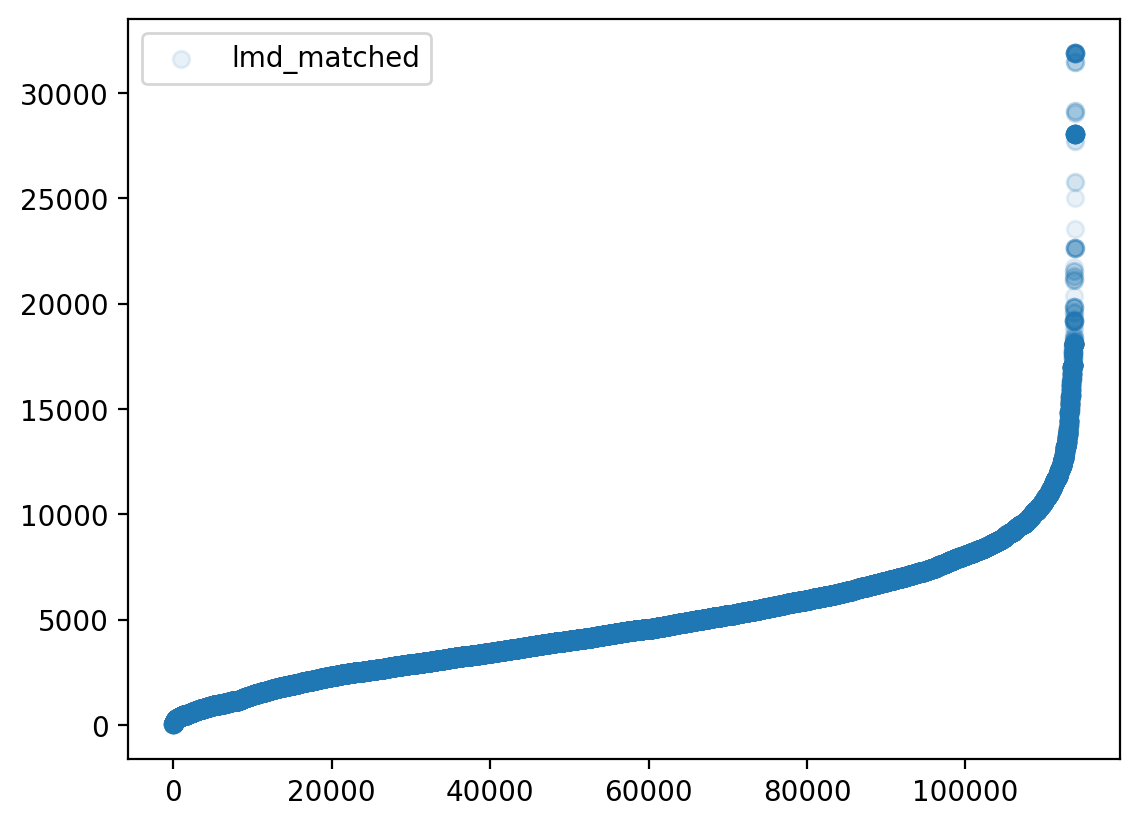

In [20]:
for y in lengths.keys():
    dataset_lengths = lengths[y]
    plt.scatter([s[0] for s in dataset_lengths], [s[1] for s in dataset_lengths], alpha=0.1)

plt.legend(chosen_datasets);

Text(0.5, 1.0, 'Deleted %')

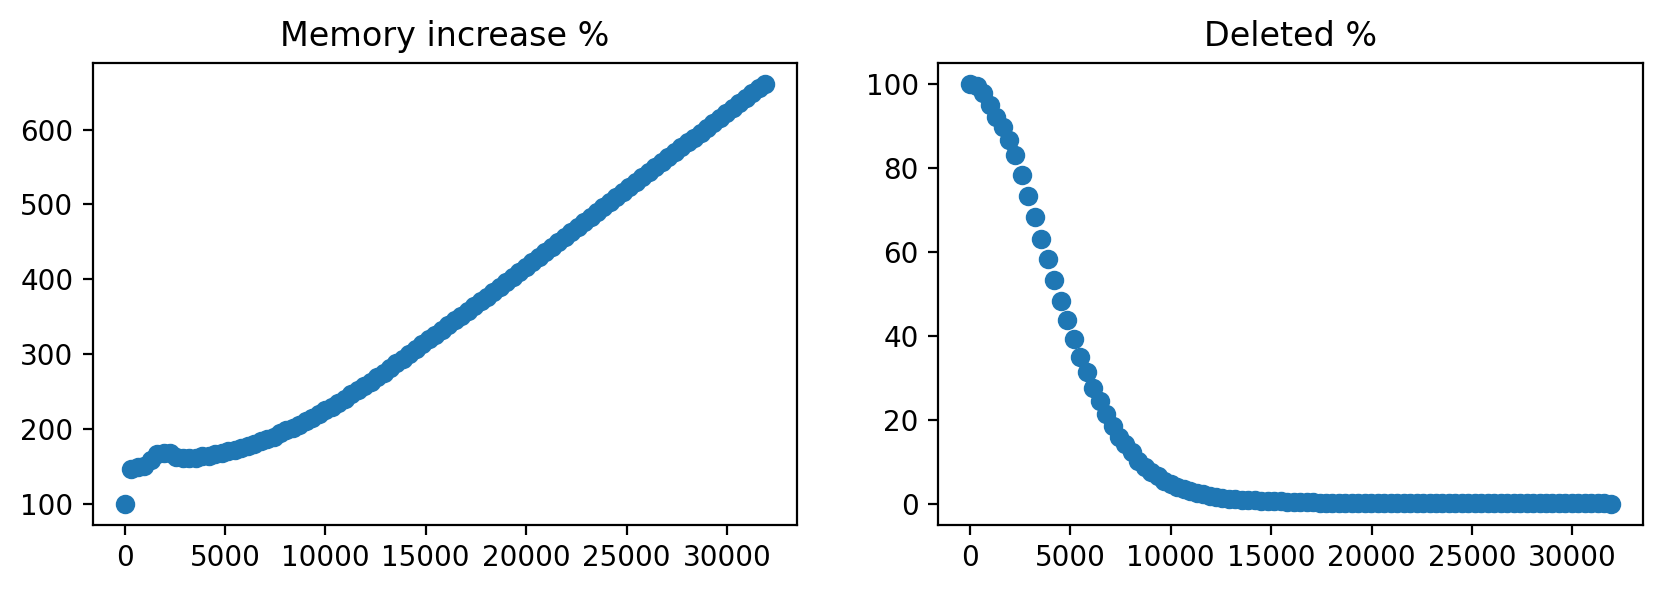

In [21]:
limits = np.linspace(min(len_x), max(len_x), 100)
deleted = []
memory = []

for i, lim in enumerate(limits):
    deleted.append(sum(1 for l in len_x if l>lim) / len(len_x) * 100)
    memory.append(sum(lim for l in len_x if l<=lim) / sum(l for l in len_x if l<=lim) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,3)
ax1.scatter(limits, memory)
ax1.set_title("Memory increase %")
ax2.scatter(limits, deleted)
ax2.set_title("Deleted %");

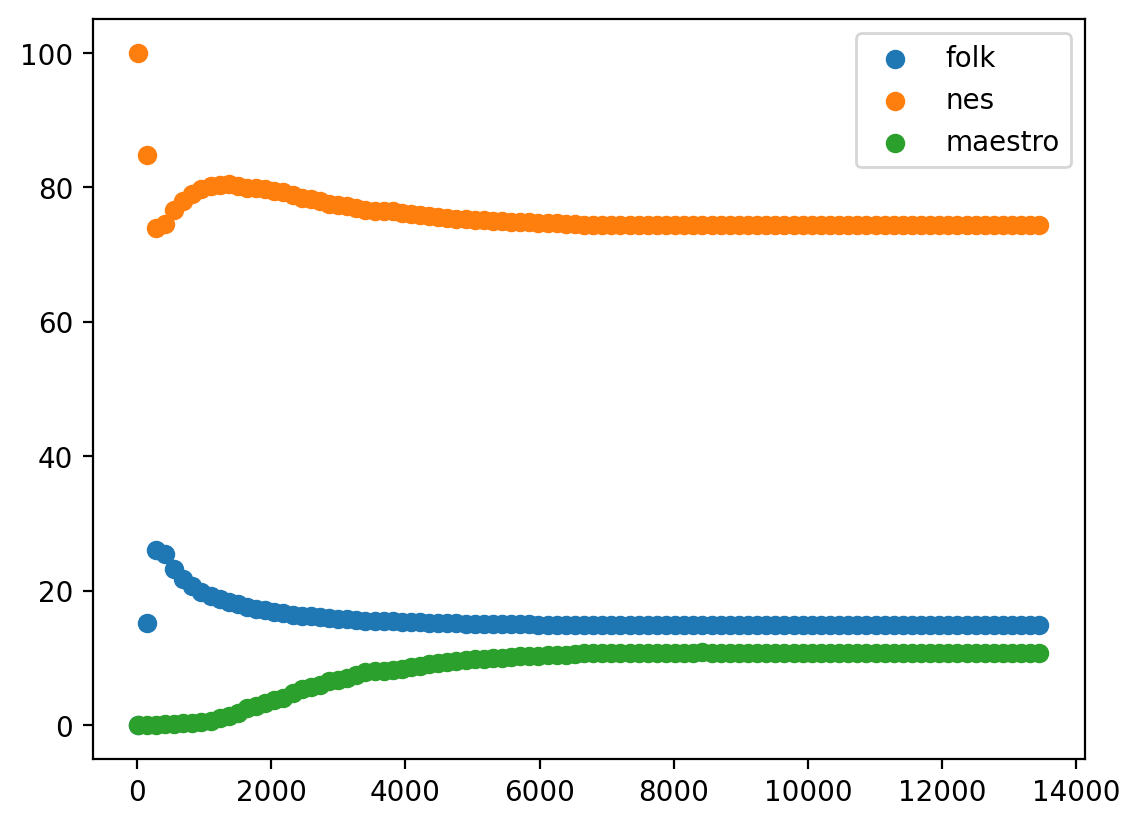

Imbalances at 100% chosen_len: 
folk: 14.80%
nes: 74.44%
maestro: 10.76%
Imbalances at len 8192: 
folk: 14.84%
nes: 74.40%
maestro: 10.76%


In [ ]:
def get_dataset_imbalance(samples, labels, names, chosen_len=None):

    processed_datasets = [[sample for sample, l in zip(samples, labels) if l == label ] for label in np.sort(np.unique(labels))]
    
    if chosen_len == None:

        min_len = np.min([np.min([len(sample) for sample in dataset]) for dataset in processed_datasets])
        max_len = np.max([np.max([len(sample) for sample in dataset]) for dataset in processed_datasets])
        
        lengths = np.linspace(min_len, max_len, 100)

        imbalances = np.zeros((len(lengths), len(processed_datasets)))

        for i, max_len_sample in enumerate(lengths):
            data_quantity = [len([1 for p in dataset if len(p)<=max_len_sample]) for dataset in processed_datasets]
            tot_data = sum(data_quantity)

            imbalances[i, :] = [d/tot_data*100 for d in data_quantity]
        
        for i in range(len(processed_datasets)):
            plt.scatter(lengths, imbalances[:, i])
        plt.legend(names)
        plt.show()

        print("Imbalances at 100% chosen_len: ")
        for name, imb in zip(names, imbalances[-1, :]):
            print("{}: {:.2f}%".format(name, imb))

        return imbalances[-1, :]

    else:
        data_quantity = [len([1 for p in dataset if len(p)<=chosen_len]) for dataset in processed_datasets]
        tot_data = sum(data_quantity)

        imbalances = [d/tot_data*100 for d in data_quantity]

        print("Imbalances at len {}: ".format(chosen_len))
        for name, imb in zip(names, imbalances):
            print("{}: {:.2f}%".format(name, imb))
        
        return imbalances

final_imbalances = get_dataset_imbalance(samples, labels, ["folk", "nes", "maestro"])

In [7]:
# can be reduced for minor memory footprint
# chosen_len = max(len(sample) for sample in samples)
chosen_len = 8192

print("With {} as max_limit, we would keep {:.2f}% of songs, {} in total".format(
    chosen_len,
    sum(1 for l in len_x if l<=chosen_len) / len(len_x) * 100,
    sum(1 for l in len_x if l<=chosen_len)
    ))

# imbalances = get_dataset_imbalance(samples, labels, ["folk", "nes", "maestro"], chosen_len=chosen_len)

With 8192 as max_limit, we would keep 99.94% of songs, 6938 in total


In [ ]:
right_shape_samples = []
right_labels = []

for sample, label in tqdm(zip(samples, labels)):
    if len(sample) <= chosen_len:
        right_shape_samples.append(
            np.concatenate((
                sample,
                np.zeros((chosen_len-len(sample), conf.tuple_size), dtype=np.uint8)
            ), dtype=np.uint8)
        )
        right_labels.append(label)

dataset = tf.data.Dataset.from_tensor_slices((right_shape_samples, right_labels))
dataset.save(conf.tf_data_path)

In [ ]:
dataset = tf.data.Dataset.load(conf.tf_data_path)

In [8]:
tf.cast(np.stack([[7]+[0]*10]*(3), axis=0), dtype=np.uint8)

<tf.Tensor: shape=(3, 11), dtype=uint8, numpy=
array([[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)>

In [21]:
samples = []
genres = []
labels = {key:[] for key in conf.INPUT_RANGES.keys()}
print(labels)
chosen_len = 6143

discarded_samples = {
    0:0, # empty song
    1:0, # time_signatures not all acceptable
    2:0, # n_measures too big
    3:0  # too many events
}

for string in chosen_datasets:
    
    pbar = tqdm(utils.get_dataset(string, conf))

    if not os.path.exists(path := os.path.join(ROOT_PATH, "data", string, "numpy")):
        os.mkdir(path)
    
    for song in pbar:
        pbar.set_description(string)

    # for i, song in enumerate(utils.get_dataset(string, conf)):
    #     if i>2:
    #         break

        converted_song = utils.transform_representation(song, conf)

        if len(converted_song) > chosen_len:
            discarded_samples[3] += 1
        elif len(converted_song) <= 1:
            discarded_samples[converted_song[0]] += 1
        else:
            padding = tf.cast(np.stack([[7]+[0]*10]*(chosen_len-len(converted_song)), axis=0), dtype=np.uint8)
            final_song = np.concatenate((
                    converted_song,
                    tf.identity(padding)
                ), dtype=np.uint8
            )
            
            samples.append(final_song)
            genres.append(utils.one_hot_encode_labels_nmf(string)) 
            
            for i, key in enumerate(labels.keys()):
                labels[key].append(final_song[:,i])
            # label = [final_song[:,i] for i in range(len(conf.INPUT_RANGES))]

            # labels.append(label)

{'type': [], 'measure': [], 'beat': [], 'position': [], 'duration': [], 'pitch': [], 'instrument': [], 'velocity': [], 'key_sign': [], 'time_sign': [], 'tempo': []}


maestro: 100%|██████████| 1276/1276 [03:34<00:00,  5.95it/s]


In [22]:
samples[0][-10:]

array([[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [23]:
print(samples[0].shape)
print(genres[0].shape)
print(len(labels["type"]))
print(labels["type"][0].shape)
# print([l.shape for l in labels[0]])

(6143, 11)
(3,)
6978
(6143,)


In [24]:
dataset = tf.data.Dataset.from_tensor_slices(((samples, genres), labels))
DATA_PATH = os.path.join(ROOT_PATH, "data/")
tf_data7dict_path = os.path.join(DATA_PATH, "tf_data7dict")
dataset.save(tf_data7dict_path)

2022-12-07 19:43:48.604892: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3772195152 exceeds 10% of free system memory.


In [25]:
dataset.batch(6)

<BatchDataset element_spec=((TensorSpec(shape=(None, 6143, 11), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.uint8, name=None)), {'type': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'measure': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'beat': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'position': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'duration': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'pitch': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'instrument': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'velocity': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'key_sign': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'time_sign': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None), 'tempo': TensorSpec(shape=(None, 6143), dtype=tf.uint8, name=None)})>

In [29]:
for batch in dataset.take(1):
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    print(batch[1])
    print(batch[0][0][-5:])


(6143, 11)
(3,)
{'type': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 1, 1, ..., 7, 7, 7], dtype=uint8)>, 'measure': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'beat': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'position': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'duration': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'pitch': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'instrument': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([ 0, 80, 38, ...,  0,  0,  0], dtype=uint8)>, 'velocity': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'key_sign': <tf.Tensor: shape=(6143,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>, 'time_sign': <tf.Tensor: shape=(6143,), dtype=uint8

### LMD_matched dataset generation with genres

In [2]:
with open(os.path.join(conf.dataset_paths["lmd_matched"], "lakh_matched_genre_vectors.pickle"), "rb") as f:
    genre_vectors = pickle.load(f)

dataset = utils.get_dataset("lmd_matched", conf)

chosen_len = 4096

In [3]:
samples = []
labels = []

discarded_samples = {
    0:0, # empty song
    1:0, # time_signatures not all acceptable
    2:0, # n_measures too big
    3:0, # too many notes
    4:0, # no genre
}

for song, genre in (pbar := tqdm(zip(dataset, genre_vectors))):
    pbar.set_description("Long dataset matched")
    if type(genre) == type(None):
        discarded_samples[4] += 1

    else:
        converted_song = utils.transform_representation(song, conf)


        if len(converted_song) > chosen_len:
            discarded_samples[3] += 1

        elif len(converted_song) <= 1:
            discarded_samples[converted_song[0]] += 1
        
        elif len(converted_song) == chosen_len:
            samples.append(converted_song, dtype=np.uint8)
            labels.append(genre)       
            
        else:
            padding = tf.cast(np.stack([[7]+[0]*10]*(chosen_len-len(converted_song)), axis=0), dtype=np.uint8)
            samples.append(
                np.concatenate((
                    converted_song,
                    tf.identity(padding)
                ), dtype=np.uint8
                )
            )
            labels.append(genre)

Long dataset: : 39950it [1:10:23,  9.46it/s]


TypeError: list.append() takes no keyword arguments

In [2]:
dataset = tf.data.Dataset.from_tensor_slices((samples, labels))
dataset.save(conf.lmda_genres_tf_data7dict_path)

NameError: name 'samples' is not defined

In [ ]:
len(samples)

In [ ]:
tot_discarded = sum(discarded_samples.values())
print("Kept {}% of the songs".format(len(dataset)/len(samples)*100))
print("Of the discarded: ")
print("- {:.2f}% were empty".format(discarded_samples[0]/tot_discarded*100))
print("- {:.2f}% contained not accepted time signatures".format(discarded_samples[1]/tot_discarded*100))
print("- {:.2f}% had too many measures".format(discarded_samples[2]/tot_discarded*100))
print("- {:.2f}% had too many events/notes".format(discarded_samples[3]/tot_discarded*100))
print("- {:.2f}% had no accepted genre".format(discarded_samples[4]/tot_discarded*100))

In [2]:
dataset = tf.data.Dataset.load(conf.lmda_genres_tf_data7dict_path)

In [3]:
samples = []
genres = []
labels = {key:[] for key in conf.INPUT_RANGES.keys()}

for sample in tqdm(dataset):
    
    song, label = sample
    
    samples.append(song)
    genres.append(label)
    
    for i, key in enumerate(labels.keys()):
        labels[key].append(song[:,i])
        
dataset = tf.data.Dataset.from_tensor_slices(((samples, genres), labels))

100%|██████████| 50472/50472 [02:33<00:00, 328.54it/s]


In [4]:
dataset.save(conf.lmda_genres_tf_data7dict_path+"_final")

In [17]:
new_samples = []
new_labels = []
for sample in tqdm(dataset):
    song = sample[0]
    label = sample[1]
    min_7 = tf.where(song[:,0] == 7)[0].numpy()[0]
    # print(song.shape)
    # print(song[:min_7,:].shape)
    # print(song[min_7-5: min_7+5,:])

    # print(tf.cast(tf.repeat([[7] + [0]*10], [conf.SEQ_LEN-min_7-1], axis=0), dtype=tf.dtypes.uint8).shape)

    new_sample = tf.concat([
            song[:min_7,:],
            tf.cast(tf.repeat([[7] + [0]*10], [conf.SEQ_LEN-min_7-1], axis=0), dtype=tf.dtypes.uint8)
        ], axis=0)

    # print(new_sample.shape)
    
    # print(new_sample[min_7-5: min_7+5,:])

    new_samples.append(new_sample)
    new_labels.append(label)

100%|██████████| 6978/6978 [00:31<00:00, 222.59it/s]


In [19]:
tf_data7_path = os.path.join(conf.DATA_PATH, "tf_data7")

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((new_samples, new_labels))
dataset.save(tf_data7_path)